In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0507MedianFilter_3_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 608ms/step - loss: 0.1057
Average validation loss: 0.5387676954269409
4/4 [==============================] - 6s 624ms/step - loss: 0.1057 - val_loss: 0.5388
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 9s 612ms/step - loss: 0.0814 - val_loss: 0.5388
Average validation loss: 0.4735233187675476
4/4 [==============================] - 9s 626ms/step - loss: 0.0814 - val_loss: 0.5061
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 632ms/step - loss: 0.0640 - val_loss: 0.5061
Average validation loss: 0.09742263704538345
4/4 [==============================] - 11s 648ms/step - loss: 0.0640 - val_loss: 0.3699
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 710ms/step - loss: 0.0065
Average validation loss: 1.9335855694357917e-09
8/8 [==============================] - 6s 721ms/step - loss: 0.0065 - val_loss: 1.9336e-09
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 707ms/step - loss: 0.0066 - val_loss: 1.9336e-09
Average validation loss: 2.5552980332577135e-05
8/8 [==============================] - 12s 721ms/step - loss: 0.0066 - val_loss: 1.2777e-05
Epoch 3/10
8/8 [==============================] - 17s 712ms/step - loss: 0.0065 - val_loss: 1.2777e-05
Average validation loss: 0.00306254078168422
8/8 [==============================] - 17s 723ms/step - loss: 0.0065 - val_loss: 0.0010    
Epoch 4/10
8/8 [==============================] - 23s 735ms/step - loss: 0.0064 - val_loss: 0.0010
Average validation loss: 0.00460306741297245
8/8 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 732ms/step - loss: 0.0084
Average validation loss: 0.33807458480199176
12/12 [==============================] - 9s 747ms/step - loss: 0.0084 - val_loss: 0.3381
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 19s 795ms/step - loss: 0.0087 - val_loss: 0.3381
Average validation loss: 0.1101060410340627
12/12 [==============================] - 19s 806ms/step - loss: 0.0087 - val_loss: 0.2241
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 28s 744ms/step - loss: 0.0085 - val_loss: 0.2241
Average validation loss: 0.03391011251369491
12/12 [==============================] - 28s 757ms/step - loss: 0.0085 - val_loss: 0.1607
Saved model weights to 'c

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 742ms/step - loss: 0.0079
Average validation loss: 0.26802430151511203
16/16 [==============================] - 12s 756ms/step - loss: 0.0079 - val_loss: 0.2680
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 24s 723ms/step - loss: 0.0077 - val_loss: 0.2680
Average validation loss: 0.040951546805445105
16/16 [==============================] - 24s 736ms/step - loss: 0.0077 - val_loss: 0.1545
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 36s 719ms/step - loss: 0.0076 - val_loss: 0.1545
Average validation loss: 0.21087964903457768
16/16 [==============================] - 36s 733ms/step - loss: 0.0076 - val_loss: 0.1733
Epoch 4/10
16/16 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 732ms/step - loss: 0.0048
Average validation loss: 0.05164051774098013
20/20 [==============================] - 15s 744ms/step - loss: 0.0048 - val_loss: 0.0516
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 717ms/step - loss: 0.0045 - val_loss: 0.0516
Average validation loss: 0.0852435973282109
20/20 [==============================] - 30s 729ms/step - loss: 0.0045 - val_loss: 0.0684
Epoch 3/10
20/20 [==============================] - 44s 736ms/step - loss: 0.0044 - val_loss: 0.0684
Average validation loss: 0.06825397165454206
20/20 [==============================] - 44s 747ms/step - loss: 0.0044 - val_loss: 0.0684
Epoch 4/10
20/20 [==============================] - 59s 719ms/step - loss: 0.0044 - val_loss: 0.0684
Average validation loss: 0.028781386443029078
20/20 [===================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 718ms/step - loss: 0.0041
Average validation loss: 0.03497069204847018
24/24 [==============================] - 18s 729ms/step - loss: 0.0041 - val_loss: 0.0350
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 724ms/step - loss: 0.0040 - val_loss: 0.0350
Average validation loss: 0.02870431449264288
24/24 [==============================] - 35s 735ms/step - loss: 0.0040 - val_loss: 0.0318
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 721ms/step - loss: 0.0039 - val_loss: 0.0318
Average validation loss: 0.019068135879933834
24/24 [==============================] - 53s 733ms/step - loss: 0.0039 - val_loss: 0.0276
Saved model weights t

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 723ms/step - loss: 0.0056
Average validation loss: 0.0252680329605937
40/40 [==============================] - 29s 736ms/step - loss: 0.0056 - val_loss: 0.0253
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 58s 721ms/step - loss: 0.0055 - val_loss: 0.0253
Average validation loss: 0.07819817438721657
40/40 [==============================] - 59s 733ms/step - loss: 0.0055 - val_loss: 0.0517
Epoch 3/10
40/40 [==============================] - 88s 732ms/step - loss: 0.0053 - val_loss: 0.0517
Average validation loss: 0.02593167796730995
40/40 [==============================] - 89s 746ms/step - loss: 0.0053 - val_loss: 0.0431
Epoch 4/10
40/40 [==============================] - 118s 734ms/step - loss: 0.0050 - val_loss: 0.0431
Average validation loss: 0.08207132406532765
40/40 [===================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 726ms/step - loss: 0.0037
Average validation loss: 0.010846722943824716
48/48 [==============================] - 36s 739ms/step - loss: 0.0037 - val_loss: 0.0108
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 720ms/step - loss: 0.0032 - val_loss: 0.0108
Average validation loss: 0.013512400707213601
48/48 [==============================] - 71s 732ms/step - loss: 0.0032 - val_loss: 0.0122
Epoch 3/10
48/48 [==============================] - 106s 727ms/step - loss: 0.0036 - val_loss: 0.0122
Average validation loss: 0.06869832379883671
48/48 [==============================] - 106s 739ms/step - loss: 0.0036 - val_loss: 0.0310
Epoch 4/10
48/48 [==============================] - 142s 732ms/step - loss: 0.0034 - val_loss: 0.0310
Average validation loss: 0.012403526340146201
48/48 [=============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 724ms/step - loss: 0.0038
Average validation loss: 0.014107634438406283
56/56 [==============================] - 41s 736ms/step - loss: 0.0038 - val_loss: 0.0141
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 718ms/step - loss: 0.0032 - val_loss: 0.0141
Average validation loss: 0.0305361129727947
56/56 [==============================] - 82s 731ms/step - loss: 0.0032 - val_loss: 0.0223
Epoch 3/10
56/56 [==============================] - 123s 720ms/step - loss: 0.0031 - val_loss: 0.0223
Average validation loss: 0.025879827635045722
56/56 [==============================] - 123s 733ms/step - loss: 0.0031 - val_loss: 0.0235
Epoch 4/10
56/56 [==============================] - 164s 721ms/step - loss: 0.0029 - val_loss: 0.0235
Average validation loss: 0.02224194226021479
56/56 [===============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 0.0033
Average validation loss: 0.014363095290541111
64/64 [==============================] - 47s 735ms/step - loss: 0.0033 - val_loss: 0.0144
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 94s 729ms/step - loss: 0.0030 - val_loss: 0.0144
Average validation loss: 0.1047790851444006
64/64 [==============================] - 95s 741ms/step - loss: 0.0030 - val_loss: 0.0596
Epoch 3/10
64/64 [==============================] - 141s 721ms/step - loss: 0.0027 - val_loss: 0.0596
Average validation loss: 0.012441355211194605
64/64 [==============================] - 142s 733ms/step - loss: 0.0027 - val_loss: 0.0439
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_80.pth'.
Epoch 4/10
64/64 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 722ms/step - loss: 0.0026
Average validation loss: 0.031045561138954427
72/72 [==============================] - 53s 734ms/step - loss: 0.0026 - val_loss: 0.0310
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 105s 725ms/step - loss: 0.0024 - val_loss: 0.0310
Average validation loss: 0.009023352564933399
72/72 [==============================] - 106s 737ms/step - loss: 0.0024 - val_loss: 0.0200
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 158s 724ms/step - loss: 0.0021 - val_loss: 0.0200
Average validation loss: 0.016748393717635836
72/72 [==============================] - 159s 737ms/step - loss: 0.0021 - val_loss: 0.0189
Epoch 4/10
72/7

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 723ms/step - loss: 0.0022
Average validation loss: 0.00906003628624603
80/80 [==============================] - 59s 735ms/step - loss: 0.0022 - val_loss: 0.0091
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 718ms/step - loss: 0.0019 - val_loss: 0.0091
Average validation loss: 0.010498174314852804
80/80 [==============================] - 117s 731ms/step - loss: 0.0019 - val_loss: 0.0098
Epoch 3/10
80/80 [==============================] - 175s 721ms/step - loss: 0.0018 - val_loss: 0.0098
Average validation loss: 0.008049461763584986
80/80 [==============================] - 176s 733ms/step - loss: 0.0018 - val_loss: 0.0092
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_100.pth'.
Epoch 4/10
80/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 720ms/step - loss: 0.0050
Average validation loss: 0.019610892451038826
96/96 [==============================] - 70s 732ms/step - loss: 0.0050 - val_loss: 0.0196
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 140s 722ms/step - loss: 0.0037 - val_loss: 0.0196
Average validation loss: 0.01784233298773567
96/96 [==============================] - 141s 734ms/step - loss: 0.0037 - val_loss: 0.0187
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 210s 721ms/step - loss: 0.0031 - val_loss: 0.0187
Average validation loss: 0.021670331800123677
96/96 [==============================] - 211s 733ms/step - loss: 0.0031 - val_loss: 0.0197
Epoch 4/10
96/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 717ms/step - loss: 0.0029
Average validation loss: 0.015034983957229997
120/120 [==============================] - 88s 729ms/step - loss: 0.0029 - val_loss: 0.0150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 174s 721ms/step - loss: 0.0024 - val_loss: 0.0150
Average validation loss: 0.007528855685571519
120/120 [==============================] - 176s 733ms/step - loss: 0.0024 - val_loss: 0.0113
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 263s 726ms/step - loss: 0.0022 - val_loss: 0.0113
Average validation loss: 0.008279044715648828
120/120 [==============================] - 264s 738ms/step - loss: 0.0022 - val_loss: 0.0103
E

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 724ms/step - loss: 0.0024
Average validation loss: 0.008456298696627427
144/144 [==============================] - 106s 736ms/step - loss: 0.0024 - val_loss: 0.0085
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 210s 720ms/step - loss: 0.0021 - val_loss: 0.0085
Average validation loss: 0.008383922275647314
144/144 [==============================] - 212s 733ms/step - loss: 0.0021 - val_loss: 0.0084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 315s 720ms/step - loss: 0.0019 - val_loss: 0.0084
Average validation loss: 0.008946510523350703
144/144 [==============================] - 317s 732ms/step - loss: 0.0019 - val_loss: 0.0086

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 115s 721ms/step - loss: 0.0018
Average validation loss: 0.006416532156936228
160/160 [==============================] - 117s 733ms/step - loss: 0.0018 - val_loss: 0.0064
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 233s 722ms/step - loss: 0.0015 - val_loss: 0.0064
Average validation loss: 0.005921191194101993
160/160 [==============================] - 235s 734ms/step - loss: 0.0015 - val_loss: 0.0062
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 352s 728ms/step - loss: 0.0014 - val_loss: 0.0062
Average validation loss: 0.005590406968485695
160/160 [==============================] - 354s 741ms/step - loss: 0.0014 - val_loss: 0.0060

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 721ms/step - loss: 0.0030
Average validation loss: 0.007636236600956181
200/200 [==============================] - 147s 733ms/step - loss: 0.0030 - val_loss: 0.0076
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 291s 720ms/step - loss: 0.0024 - val_loss: 0.0076
Average validation loss: 0.0067983671389811205
200/200 [==============================] - 293s 733ms/step - loss: 0.0024 - val_loss: 0.0072
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 438s 723ms/step - loss: 0.0021 - val_loss: 0.0072
Average validation loss: 0.00685689575257129
200/200 [==============================] - 440s 735ms/step - loss: 0.0021 - val_loss: 0.0071

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:54 - loss: 8.0471e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 174s 726ms/step - loss: 0.0020
Average validation loss: 0.016750173992174194
240/240 [==============================] - 177s 738ms/step - loss: 0.0020 - val_loss: 0.0168
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 350s 721ms/step - loss: 0.0016 - val_loss: 0.0168
Average validation loss: 0.009895742850928476
240/240 [==============================] - 353s 733ms/step - loss: 0.0016 - val_loss: 0.0133
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0507MedianFilter_3_80\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 527s 722ms/step - loss: 0.0014 - val_loss: 0.0133
Average validation loss: 0.009639729027518721
240/240 [==============================] - 530s 735ms/step - loss: 0.0014 - val_loss: 0.0121

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.05773608021188803, 0.10830807572878826, 0.13712285793714293, 0.14417064022053977, 0.036448434932432223, 0.03812613616641047, 0.047960661758465514, 0.018043107747325027, 0.023147056564988947, 0.013130602746954632, 0.009614466427576539, 0.04356169030005577, 0.010086747409955877, 0.0314980911105788, 0.007860991370253347, 0.004997299941412427, 0.006243651296336772, 0.005692663409843646]
std_val_losses =  [0.1179801356219061, 0.1147060687836666, 0.10960355908634602, 0.12724750009956529, 0.019340359081771473, 0.058803617854434345, 0.0750090633058515, 0.01842965282113669, 0.031213024900160292, 0.016401420592873747, 0.011116872106965199, 0.1090418202267445, 0.007937536672230704, 0.06436973743150741, 0.008167374393162787, 0.0022020746535028105, 0.004112552935608789, 0.003585057396407024]


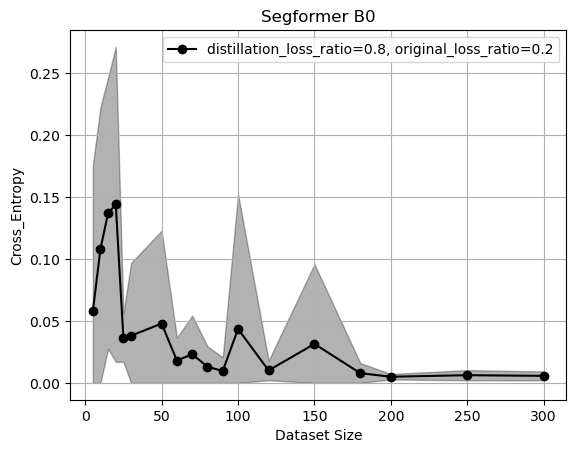

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()